In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle # For saving tokenizer and label encoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [14]:
# --- 0. Configuration ---
# Paths (ensure these are correct for your system)
DATA_FILE = r'E:\LEARN_5\XuLyNgonNguTuNhien\project\data\cleaned_data.csv'
MODEL_SAVE_DIR = r'E:\LEARN_5\XuLyNgonNguTuNhien\project\models' # Create this directory if it doesn't exist
TOKENIZER_PATH = f'{MODEL_SAVE_DIR}/tokenizer.pkl'
LABEL_ENCODER_PATH = f'{MODEL_SAVE_DIR}/label_encoder.pkl'
MAX_LEN_PATH = f'{MODEL_SAVE_DIR}/max_len.pkl'
BIGRU_MODEL_PATH = f'{MODEL_SAVE_DIR}/bigru_model.keras' # Use .keras for modern Keras saving
BILSTM_MODEL_PATH = f'{MODEL_SAVE_DIR}/bilstm_model.keras'

# Model Hyperparameters
MAX_WORDS = 10000  # Max number of words to keep in the vocabulary
MAX_LEN = 200      # Max length of sequences (pad/truncate)
EMBEDDING_DIM = 128
GRU_UNITS = 64
LSTM_UNITS = 64
EPOCHS = 20        # Adjust as needed, EarlyStopping will help
BATCH_SIZE = 32

In [15]:
# --- 1. Load and Preprocess Data ---
df_original = pd.read_csv(DATA_FILE)
df = df_original.copy()
print("5 dòng dữ liệu đầu tiên (gốc):")
print(df.head())

df.dropna(subset=['text', 'Topic'], inplace=True)
print(f"\nSố lượng mẫu sau khi loại bỏ NaN: {len(df)}")

5 dòng dữ liệu đầu tiên (gốc):
                                                text Topic
0  công_cụ trí_tuệ_nhân_tạo hữu_dụng chatgpt cạnh...    AI
1  figure_trí tuệ nhân_tạo công_ty robot hình mỹ ...    AI
2  ceo microsoft trí_tuệ_nhân_tạo đảm_nhiệm viết ...    AI
3  trí_tuệ_nhân_tạo grok musk trả_lời internet el...    AI
4  openai xác_nhận chatgpt nịnh_hót openai chatgp...    AI

Số lượng mẫu sau khi loại bỏ NaN: 16003



--- Phân tích số lượng mẫu theo chủ đề ---
Số lượng mẫu theo chủ đề TRƯỚC KHI lọc thủ công:
Topic
Giáo dục 4.0               449
Người Việt 5 châu          448
Giải trí giới sao          444
Việc làm                   443
Tin tức sức khoẻ           443
Giải trí nhạc              441
Giải trí phim              440
Ebank                      440
Dân sinh                   439
Sống khoẻ                  439
Bóng đá                    438
Giao thông                 438
Chính trị                  437
Các môn thể thao khác      436
Quân sự                    434
Hậu trường thể thao        432
Kinh doanh quốc tế         430
Nhịp sống                  428
AI                         428
Thiết bị                   427
Giải trí thời trang        426
Vũ trụ                     422
Tin tức Giáo dục           421
Sân khấu mỹ thuật          419
Chuyển đổi số              417
Thị trường xe              416
Hàng hóa                   414
Ẩm thực                    404
Tổ ấm                      404
Ch

C:\Users\Mai Xuan Truong\AppData\Local\Temp\ipykernel_11604\1410590617.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")


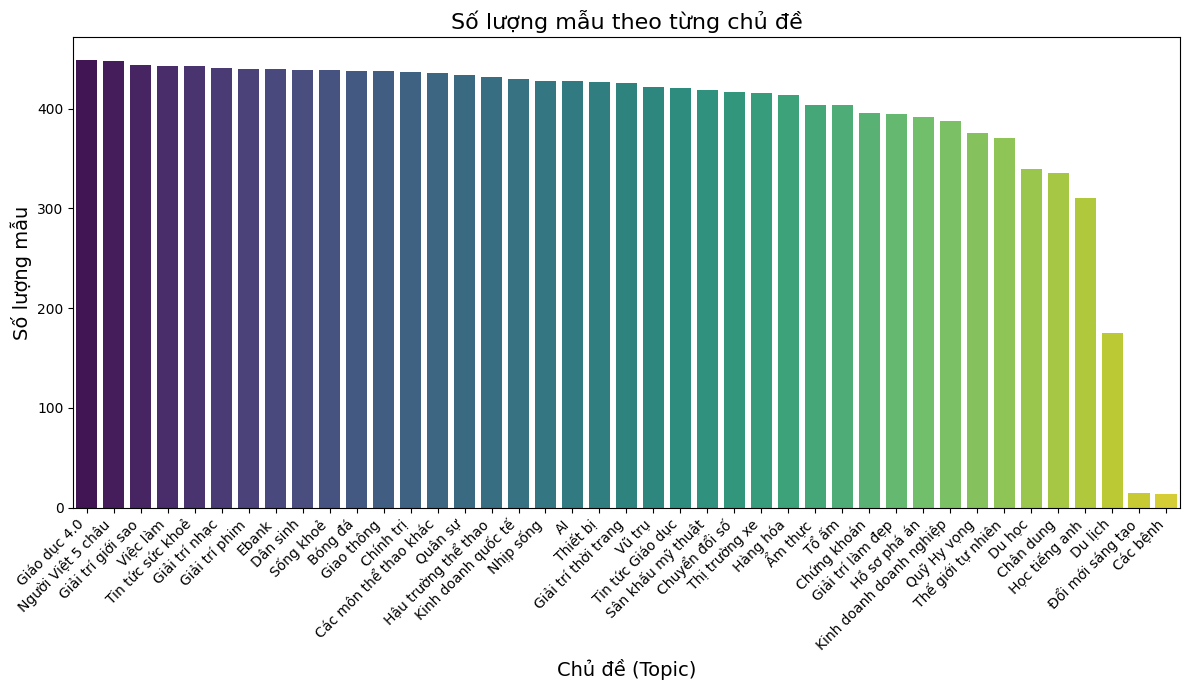

In [16]:
# --- 1.1. Phân tích số lượng mẫu theo chủ đề và cho phép loại bỏ thủ công ---
print("\n--- Phân tích số lượng mẫu theo chủ đề ---")
topic_counts = df['Topic'].value_counts()
print("Số lượng mẫu theo chủ đề TRƯỚC KHI lọc thủ công:")
print(topic_counts)

# Vẽ biểu đồ cột
plt.figure(figsize=(12, 7))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
plt.title('Số lượng mẫu theo từng chủ đề', fontsize=16)
plt.xlabel('Chủ đề (Topic)', fontsize=14)
plt.ylabel('Số lượng mẫu', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [17]:
TOPICS_TO_REMOVE = ["Du lịch", "Đổi mới sáng tạo", "Các bệnh"] # Keep this or modify as needed
df_filtered = df.copy()
if TOPICS_TO_REMOVE:
    print(f"\nCác chủ đề được chọn để loại bỏ thủ công: {', '.join(TOPICS_TO_REMOVE)}")
    actual_topics_to_remove = [topic for topic in TOPICS_TO_REMOVE if topic in df_filtered['Topic'].unique()]
    if not actual_topics_to_remove:
        print("Không có chủ đề nào trong danh sách cần loại bỏ tồn tại trong dữ liệu hiện tại.")
    else:
        print(f"Các chủ đề thực sự sẽ bị loại bỏ: {', '.join(actual_topics_to_remove)}")
        df_filtered = df_filtered[~df_filtered['Topic'].isin(actual_topics_to_remove)].copy()
        removed_count_manual = len(df) - len(df_filtered)
        print(f"Đã loại bỏ {removed_count_manual} mẫu thuộc các chủ đề trên.")
else:
    print("\nKhông có chủ đề nào được chọn để loại bỏ thủ công.")

print("\nSố lượng mẫu theo chủ đề SAU KHI lọc thủ công:")
if not df_filtered.empty:
    print(df_filtered['Topic'].value_counts())
    print(f"Tổng số lượng mẫu còn lại: {len(df_filtered)}")
else:
    print("Không còn mẫu nào sau khi lọc chủ đề.")

if df_filtered.empty:
    print("\nKhông còn dữ liệu sau khi lọc chủ đề. Dừng chương trình.")
    exit()
if df_filtered['Topic'].nunique() < 2:
    print(f"\nChỉ còn {df_filtered['Topic'].nunique()} chủ đề sau khi lọc. Cần ít nhất 2 chủ đề để phân loại. Dừng chương trình.")
    exit()

df = df_filtered


Các chủ đề được chọn để loại bỏ thủ công: Du lịch, Đổi mới sáng tạo, Các bệnh
Các chủ đề thực sự sẽ bị loại bỏ: Du lịch, Đổi mới sáng tạo, Các bệnh
Đã loại bỏ 204 mẫu thuộc các chủ đề trên.

Số lượng mẫu theo chủ đề SAU KHI lọc thủ công:
Topic
Giáo dục 4.0               449
Người Việt 5 châu          448
Giải trí giới sao          444
Việc làm                   443
Tin tức sức khoẻ           443
Giải trí nhạc              441
Giải trí phim              440
Ebank                      440
Sống khoẻ                  439
Dân sinh                   439
Giao thông                 438
Bóng đá                    438
Chính trị                  437
Các môn thể thao khác      436
Quân sự                    434
Hậu trường thể thao        432
Kinh doanh quốc tế         430
Nhịp sống                  428
AI                         428
Thiết bị                   427
Giải trí thời trang        426
Vũ trụ                     422
Tin tức Giáo dục           421
Sân khấu mỹ thuật          419
Chuyển đổi 

In [18]:
# --- 1.2. Xáo trộn (Shuffle) dữ liệu ---
print("\n--- Xáo trộn dữ liệu ---")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print("5 dòng dữ liệu đầu tiên SAU KHI xáo trộn:")
print(df.head())


--- Xáo trộn dữ liệu ---
5 dòng dữ liệu đầu tiên SAU KHI xáo trộn:
                                                text                  Topic
0  trường hàng_đầu khoa_học dữ_liệu trí_tuệ_nhân_...                 Du học
1  chatgpt dạy ngoại_ngữ openai tung demo thể_hiệ...                     AI
2  bốn tiết_kiệm chi_phí du_học australia du_học_...                 Du học
3  chocolate nguy_cơ tiểu_đường thai kỳ thai tuần...              Sống khoẻ
4  hc vàng asiad philippines hai dính doping phil...  Các môn thể thao khác


In [19]:
# --- 2. Chuẩn bị dữ liệu cho RNN ---
texts = df['text'].astype(str).values # Ensure text is string
labels_str = df['Topic'].values

In [20]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_str)
num_classes = len(label_encoder.classes_)
labels_categorical = to_categorical(labels_encoded, num_classes=num_classes)

In [21]:
# Tokenize text
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>") # <unk> for out-of-vocabulary words
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [22]:
# Pad sequences
data_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [23]:
# Save tokenizer, label encoder, and max_len (important for prediction)
import os
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # Create directory if it doesn't exist

with open(TOKENIZER_PATH, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LABEL_ENCODER_PATH, 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(MAX_LEN_PATH, 'wb') as handle:
    pickle.dump(MAX_LEN, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"\nĐã lưu Tokenizer vào: {TOKENIZER_PATH}")
print(f"Đã lưu LabelEncoder vào: {LABEL_ENCODER_PATH}")
print(f"Đã lưu MAX_LEN ({MAX_LEN}) vào: {MAX_LEN_PATH}")


Đã lưu Tokenizer vào: E:\LEARN_5\XuLyNgonNguTuNhien\project\models/tokenizer.pkl
Đã lưu LabelEncoder vào: E:\LEARN_5\XuLyNgonNguTuNhien\project\models/label_encoder.pkl
Đã lưu MAX_LEN (200) vào: E:\LEARN_5\XuLyNgonNguTuNhien\project\models/max_len.pkl


In [24]:
# --- 3. Chia dữ liệu thành tập huấn luyện và tập kiểm thử ---
X_train, X_test, y_train, y_test = train_test_split(
    data_padded, labels_categorical, test_size=0.2, random_state=42, stratify=labels_encoded # Stratify by encoded labels
)

print(f"\nKích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập kiểm thử: {X_test.shape}")
print(f"Số lớp (chủ đề): {num_classes}")
print(f"Các lớp: {label_encoder.classes_}")


Kích thước tập huấn luyện: (12639, 200)
Kích thước tập kiểm thử: (3160, 200)
Số lớp (chủ đề): 38
Các lớp: ['AI' 'Bóng đá' 'Chuyển đổi số' 'Chân dung' 'Chính trị' 'Chứng khoán'
 'Các môn thể thao khác' 'Du học' 'Dân sinh' 'Ebank' 'Giao thông'
 'Giáo dục 4.0' 'Giải trí giới sao' 'Giải trí làm đẹp' 'Giải trí nhạc'
 'Giải trí phim' 'Giải trí thời trang' 'Hàng hóa' 'Hậu trường thể thao'
 'Học tiếng anh' 'Hồ sơ phá án' 'Kinh doanh doanh nghiệp'
 'Kinh doanh quốc tế' 'Người Việt 5 châu' 'Nhịp sống' 'Quân sự'
 'Quỹ Hy vọng' 'Sân khấu mỹ thuật' 'Sống khoẻ' 'Thiết bị'
 'Thế giới tự nhiên' 'Thị trường xe' 'Tin tức Giáo dục' 'Tin tức sức khoẻ'
 'Tổ ấm' 'Việc làm' 'Vũ trụ' 'Ẩm thực']


In [25]:
# --- 4. Định nghĩa, Huấn luyện và Đánh giá Mô hình ---

def create_bilstm_model(vocab_size, embedding_dim, max_len, num_classes):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
        Bidirectional(LSTM(LSTM_UNITS, return_sequences=False)), # Only last output
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_bigru_model(vocab_size, embedding_dim, max_len, num_classes):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
        Bidirectional(GRU(GRU_UNITS, return_sequences=False)), # Only last output
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_confusion_matrix_keras(cm, classes, title):
    if not list(classes): # Check if classes is empty or all None
        print(f"Không thể vẽ ma trận nhầm lẫn cho '{title}' vì không có nhãn nào được cung cấp.")
        return
    plt.figure(figsize=(max(8, len(classes)), max(6, int(len(classes)*0.8)))) # Adjusted size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=15)
    plt.ylabel('Nhãn Thực tế (True Label)', fontsize=12)
    plt.xlabel('Nhãn Dự đoán (Predicted Label)', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


--- Mô hình BiLSTM ---
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 38)                4902      
                                                                 
Total params: 1,383,718
Trainable params: 1,383,718
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
395/395 [==============================] - 34s 45ms/step - loss: 2.9470 - acc

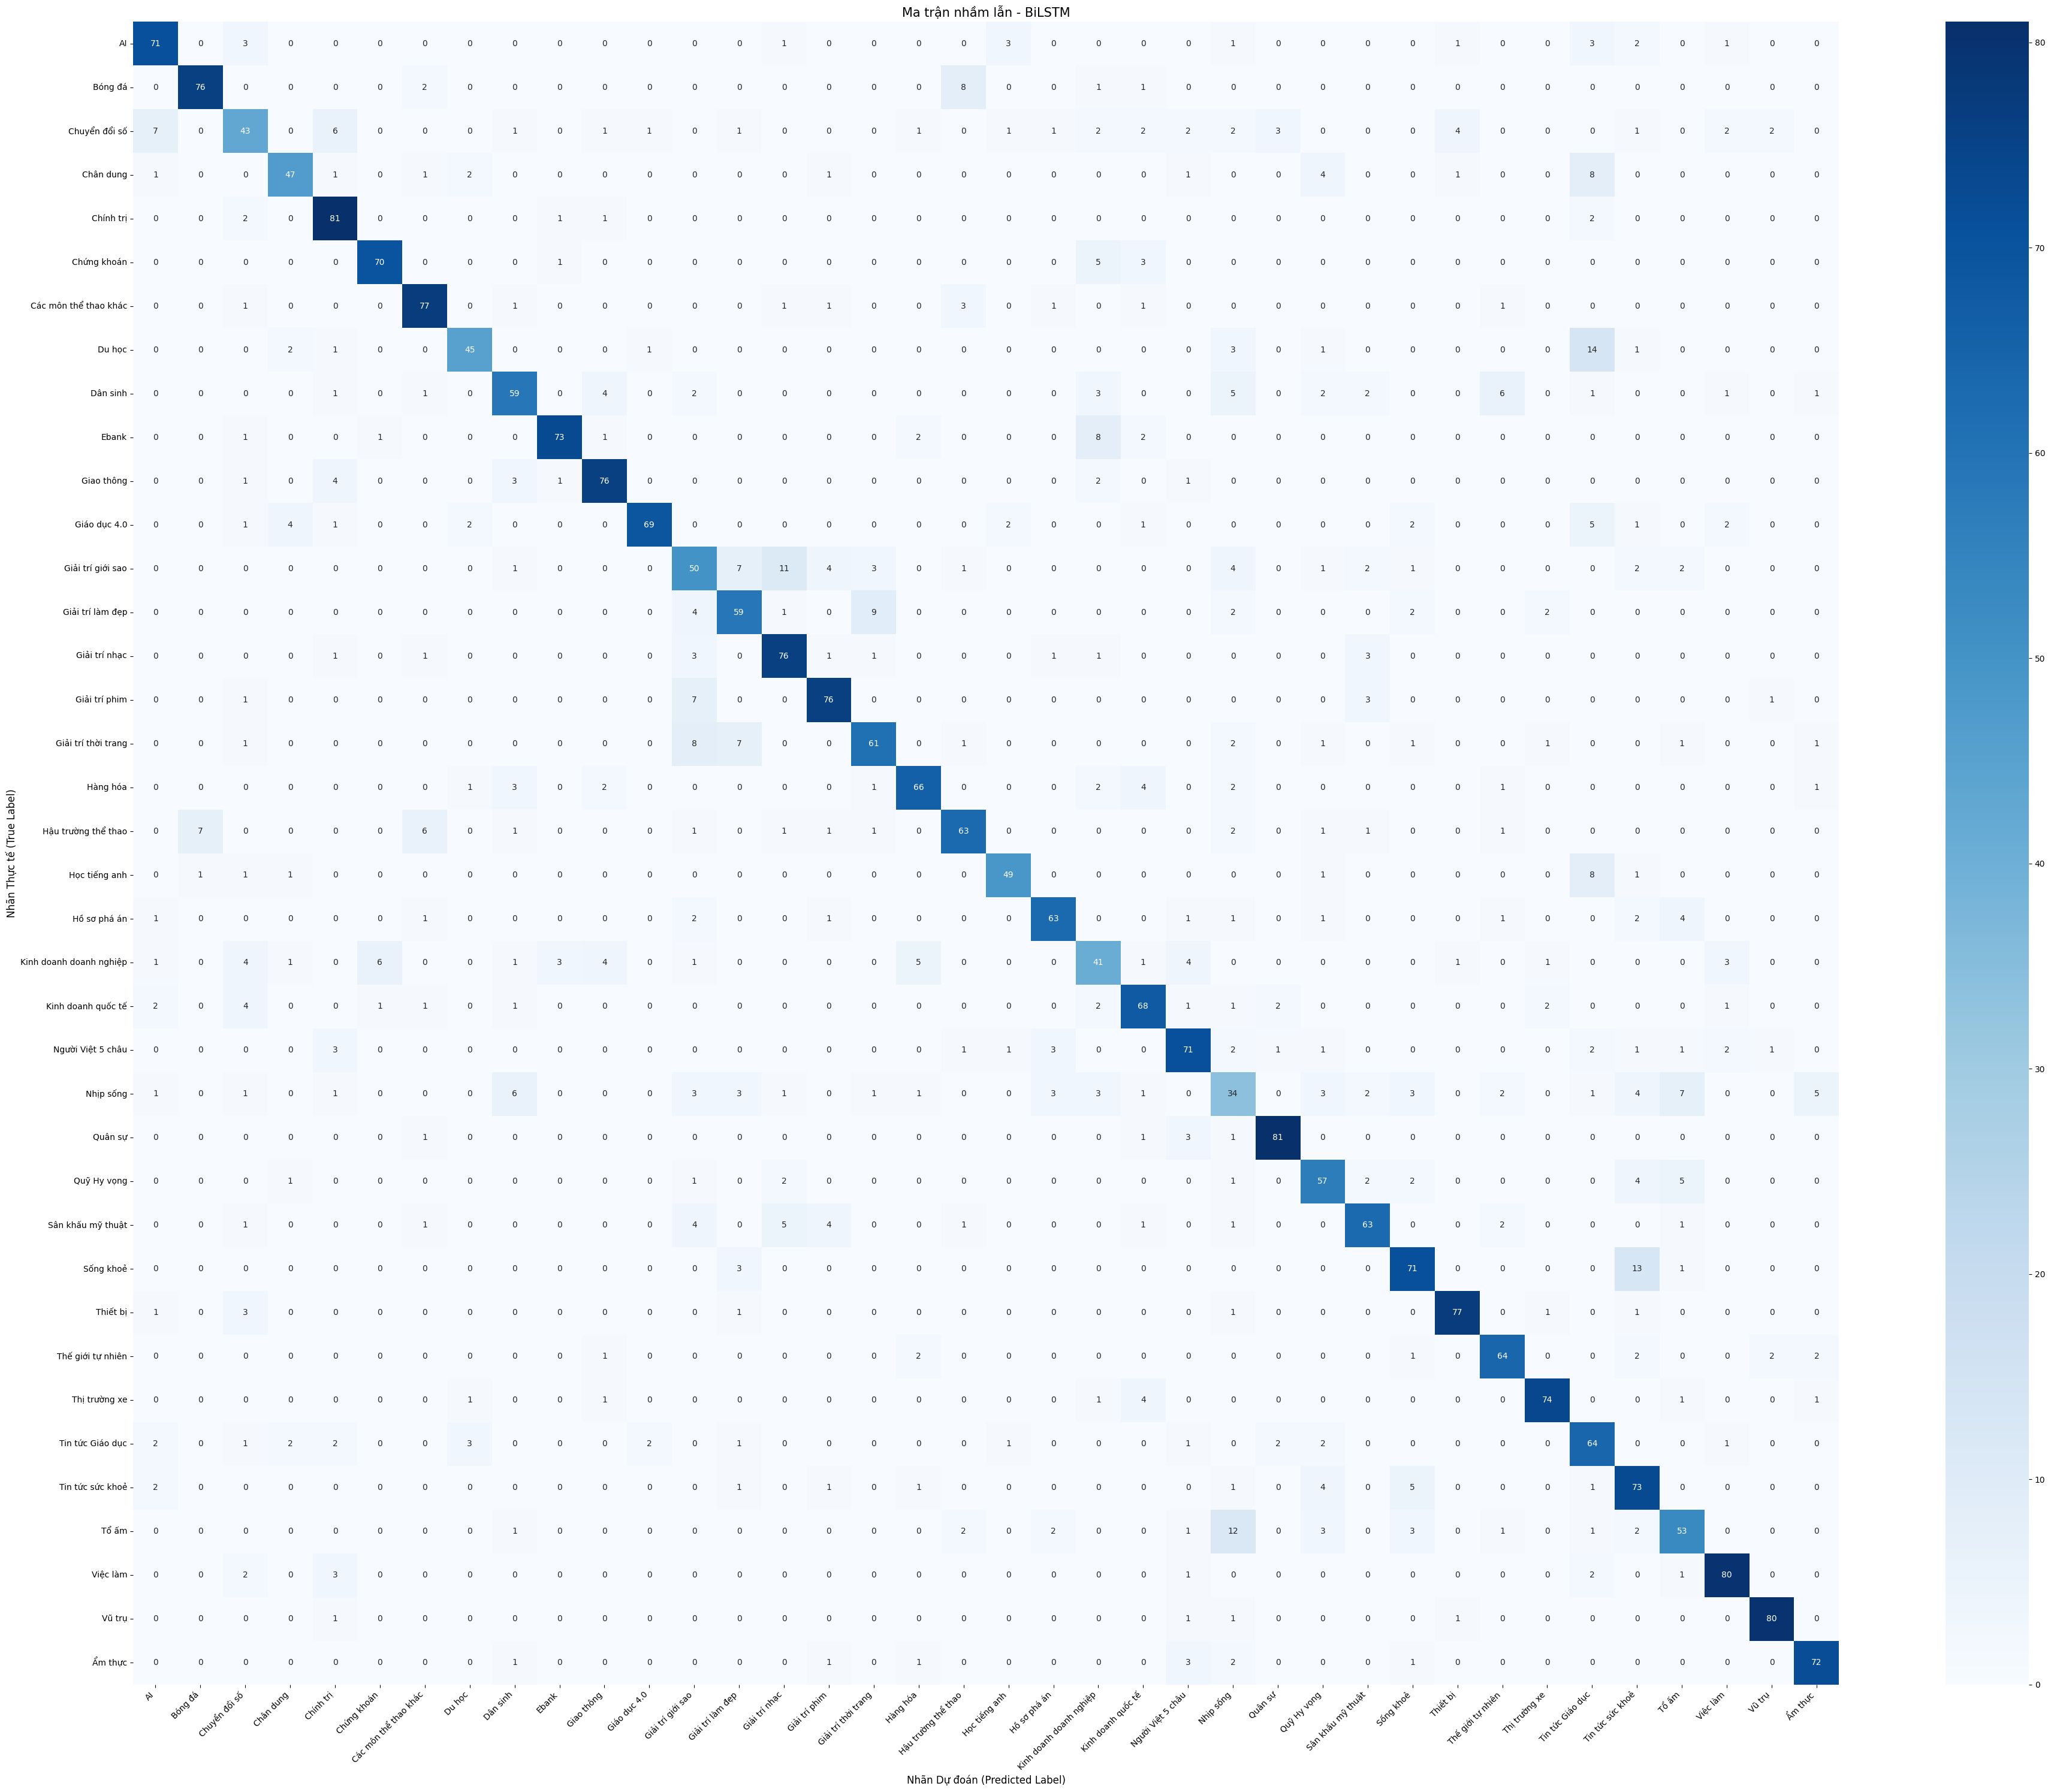

Đã lưu mô hình BiLSTM vào: E:\LEARN_5\XuLyNgonNguTuNhien\project\models/bilstm_model.keras


In [26]:
# --- 4.1. BiLSTM Model ---
print("\n--- Mô hình BiLSTM ---")
vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1) # Actual vocab size

bilstm_model = create_bilstm_model(vocab_size, EMBEDDING_DIM, MAX_LEN, num_classes)
bilstm_model.summary()

history_bilstm = bilstm_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Đánh giá
loss_bilstm, accuracy_bilstm = bilstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Độ chính xác BiLSTM (Accuracy): {accuracy_bilstm:.4f}")

y_pred_proba_bilstm = bilstm_model.predict(X_test)
y_pred_classes_bilstm = np.argmax(y_pred_proba_bilstm, axis=1)
y_test_classes = np.argmax(y_test, axis=1) # Convert one-hot back to class indices for sklearn metrics

print("Báo cáo phân loại BiLSTM (Classification Report):")
print(classification_report(y_test_classes, y_pred_classes_bilstm, labels=np.arange(num_classes), target_names=label_encoder.classes_, zero_division=0))

cm_bilstm = confusion_matrix(y_test_classes, y_pred_classes_bilstm, labels=np.arange(num_classes))
plot_confusion_matrix_keras(cm_bilstm, label_encoder.classes_, 'Ma trận nhầm lẫn - BiLSTM')

# Lưu mô hình BiLSTM
bilstm_model.save(BILSTM_MODEL_PATH)
print(f"Đã lưu mô hình BiLSTM vào: {BILSTM_MODEL_PATH}")


--- Mô hình BiGRU ---
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 38)                4902      
                                                                 
Total params: 1,359,398
Trainable params: 1,359,398
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
395/395 [==============================] - 40s 83ms/step - loss: 2.9195 - ac

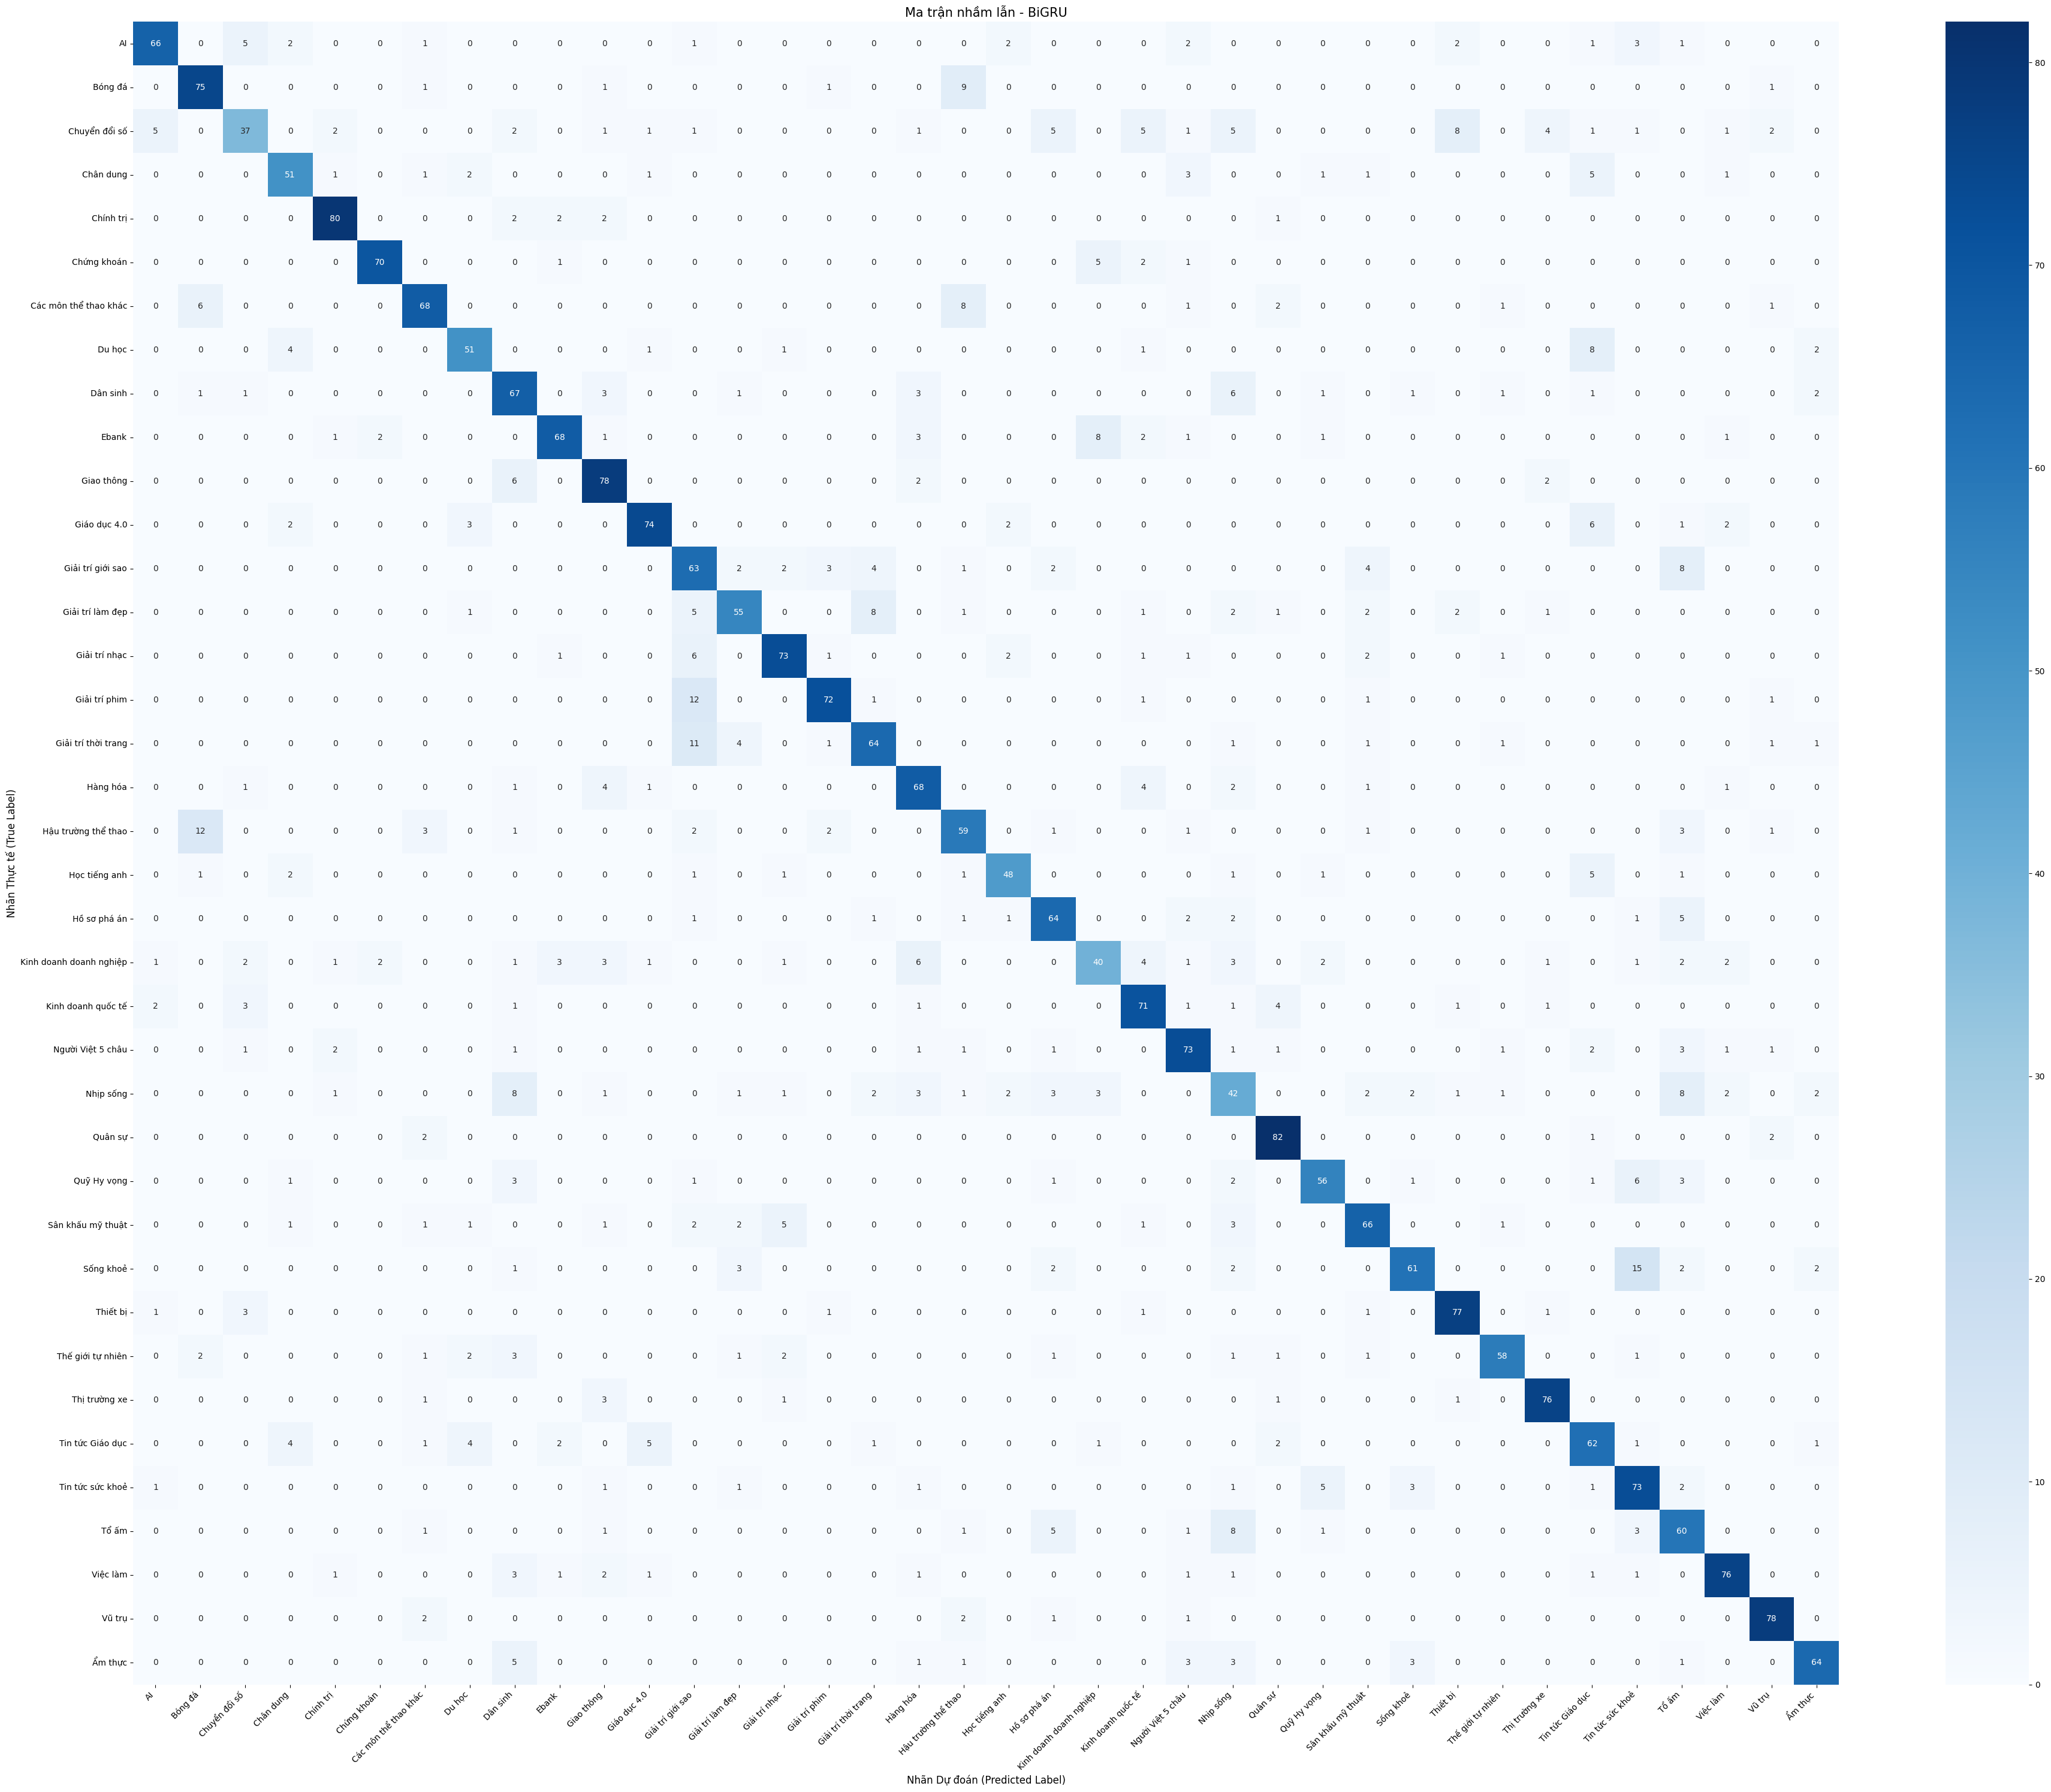

Đã lưu mô hình BiGRU vào: E:\LEARN_5\XuLyNgonNguTuNhien\project\models/bigru_model.keras

--- Hoàn thành huấn luyện và lưu mô hình ---


In [27]:
# --- 4.2. BiGRU Model ---
print("\n--- Mô hình BiGRU ---")
bigru_model = create_bigru_model(vocab_size, EMBEDDING_DIM, MAX_LEN, num_classes)
bigru_model.summary()

history_bigru = bigru_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Đánh giá
loss_bigru, accuracy_bigru = bigru_model.evaluate(X_test, y_test, verbose=0)
print(f"Độ chính xác BiGRU (Accuracy): {accuracy_bigru:.4f}")

y_pred_proba_bigru = bigru_model.predict(X_test)
y_pred_classes_bigru = np.argmax(y_pred_proba_bigru, axis=1)
# y_test_classes is the same as above

print("Báo cáo phân loại BiGRU (Classification Report):")
print(classification_report(y_test_classes, y_pred_classes_bigru, labels=np.arange(num_classes), target_names=label_encoder.classes_, zero_division=0))

cm_bigru = confusion_matrix(y_test_classes, y_pred_classes_bigru, labels=np.arange(num_classes))
plot_confusion_matrix_keras(cm_bigru, label_encoder.classes_, 'Ma trận nhầm lẫn - BiGRU')

# Lưu mô hình BiGRU
bigru_model.save(BIGRU_MODEL_PATH)
print(f"Đã lưu mô hình BiGRU vào: {BIGRU_MODEL_PATH}")

print("\n--- Hoàn thành huấn luyện và lưu mô hình ---")

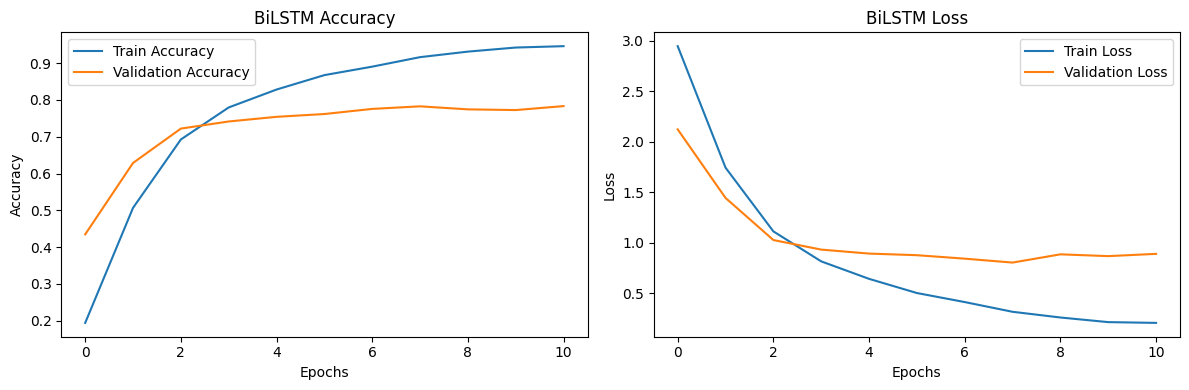

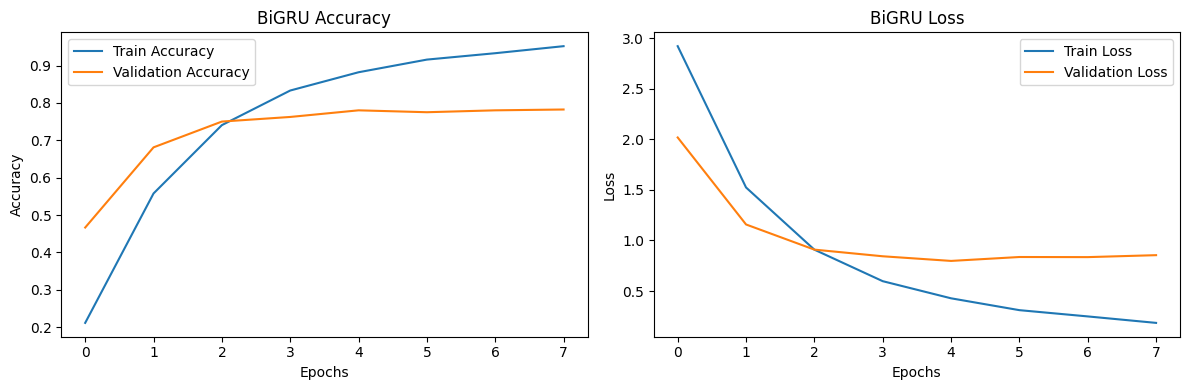

In [28]:
# Plot training history (optional)
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(history_bilstm, "BiLSTM")
plot_training_history(history_bigru, "BiGRU")
